# Implementation of Spectral multidomain technique with Local Fourier Basis
Israeli, M., Vozovoi, L. & Averbuch, A. Spectral multidomain technique with Local Fourier Basis. J Sci Comput 8, 135–149 (1993). https://doi.org/10.1007/BF01060869

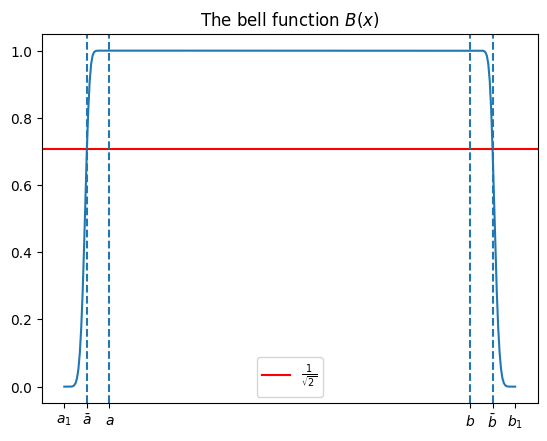

In [131]:
import spectral_derivative as sd
import numpy as np 
import matplotlib.pyplot as plt

L                 = 1
N                 = 256
dx                = L/(N - 1)
ghostBoundary     = 32
x                 = np.arange(-ghostBoundary, N + ghostBoundary) * dx

def theta(x, eps): 
    return np.pi/4 * ( 1 + np.sin( np.pi/2 * np.sin( np.pi/2 * np.sin ( np.pi/2 * x / eps ))))
    #return np.pi/4 * ( 1 + np.sin( np.pi/2 * x/eps ))
    #return x * 2 * np.pi
    
def sfunc(x, eps):
    return np.sin(theta(x, eps))

def cfunc(x, eps):
    return np.cos(theta(x, eps))

def bfunc(x, a1, a, b1, b):
    B = np.zeros(x.shape) 
    eps  = (b1 - b) / 2

    c = (x >= a1) * (x <= a)
    B[ c ] = sfunc( x[c] + eps, eps ) 
    c = (x >= a) *  (x <= b)
    B[ c ] = 1
    c = (x > b) * (x <= b1)
    B[ c ] = cfunc( x[c] - eps - b, eps)
    return B 

a1 =   - ghostBoundary * dx  
a  =     0
b  =     L 
b1 =   + ghostBoundary * dx  + L 
ab = (a + a1)/2
bb = (b + b1)/2
plt.title(r"The bell function $B(x)$") 
plt.plot(x, bfunc(x, a1, a, b1, b)) 
plt.axhline(1/np.sqrt(2), label=r"$\frac{1}{\sqrt{2}}$", c="r")
plt.axvline(a, ls="dashed")
plt.axvline(b, ls="dashed")
plt.axvline(ab, ls="dashed")
plt.axvline(bb, ls="dashed")
plt.xticks(ticks=[a1, ab, a, b, bb, b1], labels=[r"$a_1$", r"$\bar{a}$", r"$a$", r"$b$", r"$\bar{b}$", r"$b_1$", ])
plt.legend()
plt.show()



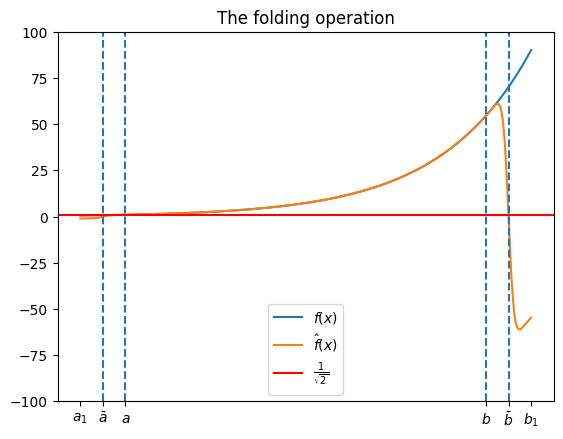

In [149]:

fdl               = 0
fdr               = 0
BC                = sd.PERIODIC
mode              = sd.M_POLYNOMIAL
derivativeMode    = sd.ONE_SIDED
smoothingOrder    = 5

name = "Linear k=4 one-sided"

k = 4

def func(x):
    return np.exp(x * k)

def ddfunc(x):
    return k**2 * np.exp(x * k)
f      =   func(x)
ddfana = ddfunc(x)
B      = bfunc(x, a1, a, b1, b)
def folding(x, func, bfunc): 
    return bfunc(x, a1, a, b1, b) * func(x) - bfunc(2 * ab - x, a1, a, b1, b) * func(2 * ab - x) - bfunc(2 * bb - x, a1, a, b1, b) * func(2 * bb - x)

def fhat(f, B): 
    return f * B - np.flip(np.roll(B * f, -ghostBoundary)) - np.roll(B * f, ghostBoundary)


plt.title(r"The folding operation") 
plt.plot(x, func(x), label=r"$f(x)$") 
plt.plot(x, folding(x, func, bfunc), label=r"$\hat{f}(x)$") 
plt.axhline(1/np.sqrt(2), label=r"$\frac{1}{\sqrt{2}}$", c="r")
plt.axvline(a, ls="dashed")
plt.axvline(b, ls="dashed")
plt.axvline(ab, ls="dashed")
plt.axvline(bb, ls="dashed")
plt.ylim([-100, 100])
plt.xticks(ticks=[a1, ab, a, b, bb, b1], labels=[r"$a_1$", r"$\bar{a}$", r"$a$", r"$b$", r"$\bar{b}$", r"$b_1$", ])
plt.legend()
plt.show()


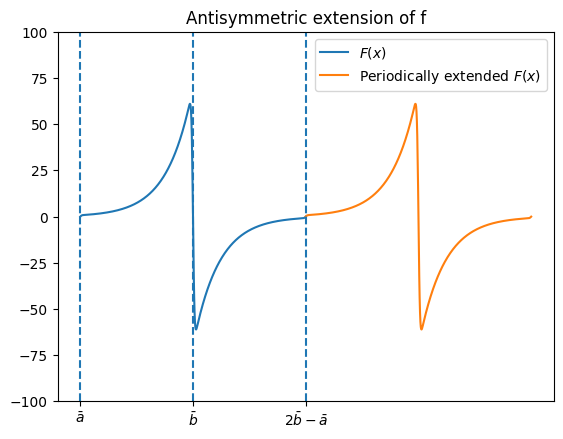

In [145]:

def Ffunc(x, func, bfunc):
    Nh  = N + ghostBoundary
    Nl  =  Nh * 2 - 1
    xl  = np.arange(-ghostBoundary/2, N + ghostBoundary/2) * dx
    # Exclude left boundary since it agrees with right boundary of xl
    xh = (xl + bb - ab)[1:]
    X  = np.arange(-ghostBoundary/2, Nl-ghostBoundary/2) * dx
    F  = np.zeros(Nl)
    F[:Nh] = folding(         xl, func, bfunc) 
    F[Nh:] = -folding(2 * bb - xh, func, bfunc)
    return X, F 

X, F = Ffunc(x, func, bfunc)

L = 2*bb - 2*ab
plt.title(r"Antisymmetric extension of f") 
plt.plot(X, F, label=r"$F(x)$") 
plt.plot(X + L, F, label=r"Periodically extended $F(x)$") 
plt.axvline(ab, ls="dashed")
plt.axvline(bb, ls="dashed")
plt.axvline(2 * bb - ab, ls="dashed")
plt.ylim([-100, 100])
plt.xticks(ticks=[ab, bb, 2 * bb - ab, ], labels=[r"$\bar{a}$", r"$\bar{b}$", r"$2 \bar{b} - \bar{a}$", ])
plt.legend()
plt.show()


In [151]:
import spectral_derivative as sd 
BC = sd.PERIODIC
p, ind1, ind2   = sd.selectBC       (F, BC)
ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= False)
ddfnum = ddf[int(ghostBoundary/2):int(N+ghostBoundary/2)]

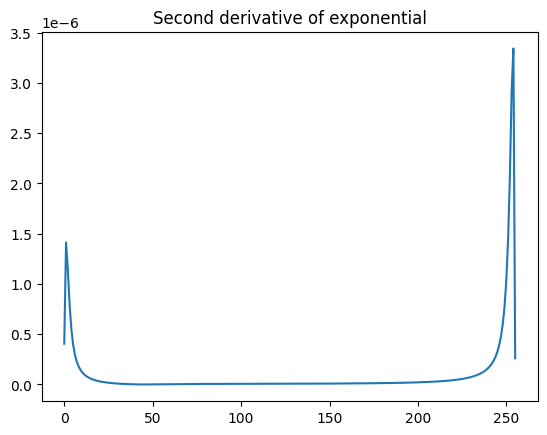

In [153]:
plt.title("Second derivative of exponential") 
plt.plot(np.abs(ddfnum - ddfana[ghostBoundary:-ghostBoundary])/ddfana[ghostBoundary:-ghostBoundary])
plt.show()

In [ ]:

orders = [3]

#Create shift function that such that f - B fulfills either Dirichlet, Neumann or periodic boundary conditions depending on mode
B, poly = sd.getShiftFunction(x, f, mode, derivativeMode, lb = fdl, rb = fdr, N = smoothingOrder, debug=True)

#Boundary for finite difference stencil
lind =          fdl
rind = len(x) - fdr 

#Subtract linear shift function to enforce Dirichlet BC when computing second derivative
homf            = f[ lind : rind ] - B[0]

fextend         = np.concatenate([homf, -np.flip(homf[:-1])])
plt.title(f"Length of fextend = {len(fextend)}")
plt.plot(fextend)
plt.show()
print(fextend)
p, ind1, ind2   = sd.selectBC       (fextend, BC)
print(len(p))
ddf, k          = sd.laplacianDtt1D (p, dx, BC, debug= True)
plt.plot(ddf.real)
plt.show()
ddfana          = ddf.real[:32] + B[1]


fig, axs = plt.subplots(nrows=len(orders), ncols=2, sharex=True, figsize=(6, len(orders) * 3)) 
fig.suptitle(name)

axs[0].plot([], label= f"Smoothing order = {smoothingOrder} RMS error = {np.mean(np.abs(ddfnum - ddfana)[ghostBoundary:-ghostBoundary]):3.3e}")
axs[0].plot(ddfnum, label="num")
axs[0].plot(ddfana, label="ana")
axs[0].legend()
axs[1].set_yscale("log")
axs[1].plot(np.abs((ddfnum-ddfana)/ddfana), label="num")
axs[1].axvspan(0, ghostBoundary, alpha=0.4)
axs[1].axvspan(len(ddfnum) - ghostBoundary, len(ddfnum), alpha=0.4)
plt.show()